<a href="https://colab.research.google.com/github/nubiochenko/estudos/blob/main/C%C3%B3pia_de_Helios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [1]:
!pip install pandas fiona shapely pyproj rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00


In [2]:
!pip install geopandas
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 14.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
from shapely.geometry import Point
from math import floor
from pyproj import Proj
import matplotlib.pyplot as plt
from math import floor
import shapely
from shapely.geometry import Polygon, MultiPolygon
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans

# Utils

In [ ]:
print("parquet da rodada HS")
parquet = files.upload()
print("shapefile de APPs")
shp_app = files.upload()
print("shapefile das fazendas")
shp_field = files.upload()
print("geotiff SRTM raster")
raster_gtif = files.upload()
print("tabela csv com dados de altimetria das fazendas")
csv_dem = files.upload()

parquet da rodada HS


Saving helios_score.parquet to helios_score (1).parquet
shapefile de APPs


Saving app_junq.zip to app_junq (1).zip
shapefile das fazendas


Saving junq_poly_hs_sirgass.zip to junq_poly_hs_sirgass.zip
geotiff SRTM raster


Saving clip_DEM_teste_wgs.tif to clip_DEM_teste_wgs (1).tif
tabela csv com dados de altimetria das fazendas


Saving dem_files.csv to dem_files.csv


In [ ]:
parquet_heliosscore_path = list(parquet)[0]
app_shp_field_path = list(shp_app)[0]
raster_gtif_path = list(raster_gtif)[0]
shp_field_path = list(shp_field)[0]
csv_dem_path = list(csv_dem)[0]

# Classes

In [ ]:
class HeliosProject:
  def  __init__(self, dict_input_data):
    self.raster = dict_input_data['raster'] #raster elevation SRTM
    self.field_shp = dict_input_data['field_shapefiles'] #Regular shapefile Farm Fields
    self.ppa_shp = dict_input_data['ppa_shapefiles'] #Permanent Preservation Areas
    self.hs_parquet = dict_input_data['hs_files'] #Helios Score + Farm Fields Shapefile
    self.table_elevation = dict_input_data['xlsx_elevation_table'] #xlsx table with sigkey and average elevation by farm fields

  def convert_vectorfiles_into_spatial_data(self):
    print('creating shapefile spatial location to the farms: farm_shapefiles')
    self.farm_shapefiles = gpd.read_file(self.field_shp[0])

    print('creating shapefile spatial PPA - Permanent Preservation Areas: ppa_shapefile')
    ppa_shapefile = gpd.read_file(self.ppa_shp[0])
    df_attribute = pd.DataFrame([0], columns=['distancia_buff'])
    ppa_shapefile = gpd.GeoDataFrame(df_attribute, geometry=ppa_shapefile.geometry)

    print('dissoving polygons')
    self.ppa_shapefile = ppa_shapefile.dissolve()
    return(True)

  def reprojection(self, gpd_shapefile, utm_or_geo_projection):
    print('projection interpretation and analysis')
    bbox_table = gpd_shapefile.bounds
    long_avg = bbox_table[['minx', 'maxx']].stack().dropna().mean()

    self.datum_geo = "epsg:4326"

    if utm_or_geo_projection:
      print('tranforming GEO projection to UTM')
      print("calculating UTM zone from geometry")
      utm_zone = floor(31 + (long_avg/6))
      self.datum_utm = "epsg:327{}".format(utm_zone)
      gpd_shapefile = gpd_shapefile.to_crs(self.datum_utm)
      return(gpd_shapefile)

    print('tranforming UTM projection to GEO')
    gpd_shapefile = gpd_shapefile.to_crs(self.datum_geo)
    return(gpd_shapefile)

  def defining_aoi_shapefiles(self, ppa_shp_farms, farm_shp):
    print("Let me define all shapefile bounds...")
    spatial_pol_ppa = shapely.wkt.loads(ppa_shp_farms.geometry.to_wkt().values[0])

    farm_shp_dissolved = farm_shp.buffer(max(self.list_buffer_dist))
    farm_shp_dissolved = gpd.GeoDataFrame(geometry=farm_shp_dissolved).dissolve()
    farm_shp_dissolved = shapely.wkt.loads(farm_shp_dissolved.geometry.to_wkt().values[0])

    self.aoi_ppa_shapefile = spatial_pol_ppa.intersection(farm_shp_dissolved)
    self.farm_shp_dissolved = gpd.GeoDataFrame(farm_shp_dissolved, columns=['geometry'])
    return(type(self.aoi_ppa_shapefile))

  def buffer_sequencies(self):
    geom_list = []
    minimum_dist = min(self.list_buffer_dist)

    geom_border = self.aoi_ppa_shapefile.buffer(minimum_dist)
    geom_list.append(geom_border)

    for dist in self.list_buffer_dist:
      if dist == minimum_dist:
        continue
      print(f'calculating border buffer for ppa {dist}m')
      geom_border = self.aoi_ppa_shapefile.buffer(dist)
      geom_border = self.aoi_ppa_shapefile.buffer(dist - minimum_dist).symmetric_difference(geom_border)
      geom_list.append(geom_border)

    listweight_buff = sorted(self.list_buffer_dist, reverse=True)
    self.aoi_ppa_shapefile = gpd.GeoDataFrame({'buff_ppa':listweight_buff}, geometry = gpd.GeoSeries(geom_list))
    return(True)

  def create_grid_area(self, farm_shp, cell_size):
    print('definig my bbox')
    xmin, ymin, xmax, ymax= farm_shp.total_bounds
    print(f'my bbox with {xmax - xmin} m of width and {ymax - ymin} m of heigth')

    grid_cells = []
    print("as I define my cell size, I can define the whole area and find out how many square cells I'll get")
    for x0 in np.arange(xmin, xmax + cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    print('that is a different geom called grid, that means a regular polygon but in sequence disposition')
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                            crs=self.datum_utm)


    self.cell = gpd.sjoin(cell, self.farm_shp_dissolved, how='inner', op='intersects')
    return(True)

  def read_table_data(self, list_columns, encode, separate):
    self.table_elevation = pd.read_csv(self.table_elevation[0],
                                       encoding=encode,
                                       sep=separate)[list_columns]
    pass

  def join_table_elevation_to_geom(self, farm_shp, elevation_table,
                                   farm_shp_column_key, table_elevation_key):
    print('regular merge tables between csv elevation table and geopandas df')
    elevation_farm_shp = farm_shp.merge(elevation_table, how='left', left_on='CHAVEZONA', 
                                        right_on='farm_zone')
    return(elevation_farm_shp)

  def read_geotiff(self):
    self.geotiff = rasterio.open(self.raster[0])
    pass

  def convert_geotiff(self, datum):
    with rasterio.open(self.raster[0]) as src:
        transform, width, height = calculate_default_transform(
            src.crs, datum, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': datum,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(self.raster[0], 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=datum,
                    resampling=Resampling.nearest)
    print(f'converting gtiff to datum {datum}')            
    self.geotiff = rasterio.open(self.raster[0])
    pass

  def extract_raster_values_to_vector_cells(self, value_name, raster):
    print('extract all centroid values')
    coord_list = [(x, y) for x, y in zip(self.cell.centroid.x , self.cell.centroid.y)]

    self.cell[value_name] = [values[0] for values in raster.sample(coord_list)]
    pass

  def filter_columns(self, df, list_columns):
    return(df[list_columns])

  def create_spatial_from_df(self, df, datum):
    table_info_geom = gpd.GeoDataFrame(df,
                                       geometry=df.geometry,
                                       crs=datum)
    return(table_info_geom)

  def merge_data_to_grid_vector(self, shp, cell_grid):
    
    cell_grid = cell_grid.sjoin(shp, 
                                how="left",
                                predicate='intersects')
    return(cell_grid)


class DataScience(HeliosProject):
  def __init__(self, dict_input_data, list_buffer_dist):
    self.list_buffer_dist = list_buffer_dist
    pass
  

class DataEngineer(HeliosProject):
  def __init__(self, dict_input_data):
    super().__init__(dict_input_data)
    pass


# Main

In [ ]:
dict_input_data = {'raster':[raster_gtif_path], 'field_shapefiles':[shp_field_path], 'ppa_shapefiles':[app_shp_field_path],
                   'hs_files':[parquet_heliosscore_path], 'xlsx_elevation_table':[csv_dem_path]}

list_buffer_distances = [250, 500, 750]

In [ ]:
rafa_ferreira = DataEngineer(dict_input_data)
diegao = DataScience(dict_input_data, list_buffer_distances)

rafa_ferreira.convert_vectorfiles_into_spatial_data()

ppa_shp_farms = diegao.reprojection(rafa_ferreira.ppa_shapefile, True)
farm_shp = diegao.reprojection(rafa_ferreira.farm_shapefiles, True)

rafa_ferreira.read_table_data(['sig_key', 'farm_zone', 'Mediana_Altimetria'], 
                              'latin-1', 
                              ';')

farm_elevation_shp = rafa_ferreira.join_table_elevation_to_geom(farm_shp,
                                                                rafa_ferreira.table_elevation, 
                                                                farm_shp_column_key='CHAVEZONA', 
                                                                table_elevation_key='farm_zone')

farm_elevation_shp = rafa_ferreira.filter_columns(farm_elevation_shp,
                                                  ['geometry', 'farm_zone', 'Mediana_Altimetria', 'HS'])

diegao.defining_aoi_shapefiles(ppa_shp_farms, farm_shp)
diegao.buffer_sequencies()

diegao.create_grid_area(farm_shp, 1000)

rafa_ferreira.read_geotiff()
rafa_ferreira.convert_geotiff(diegao.datum_utm)

diegao.extract_raster_values_to_vector_cells('elevation_data',
                                             rafa_ferreira.geotiff)

farm_elevation_shp = rafa_ferreira.create_spatial_from_df(farm_elevation_shp, diegao.datum_utm)


creating shapefile spatial location to the farms: farm_shapefiles
creating shapefile spatial PPA - Permanent Preservation Areas: ppa_shapefile
dissoving polygons
projection interpretation and analysis
tranforming GEO projection to UTM
calculating UTM zone from geometry
projection interpretation and analysis
tranforming GEO projection to UTM
calculating UTM zone from geometry
regular merge tables between csv elevation table and geopandas df
Let me define all shapefile bounds...
calculating border buffer for ppa 500m
calculating border buffer for ppa 750m
definig my bbox
my bbox with 76153.53206651815 m of width and 82821.86780601554 m of heigth
as I define my cell size, I can define the whole area and find out how many square cells I'll get
that is a different geom called grid, that means a regular polygon but in sequence disposition


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32723
Right CRS: None



converting gtiff to datum epsg:32723
extract all centroid values


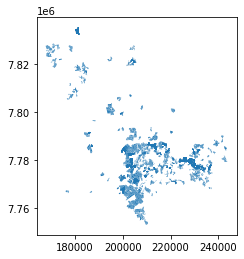

In [ ]:
farm_elevation_shp.plot()

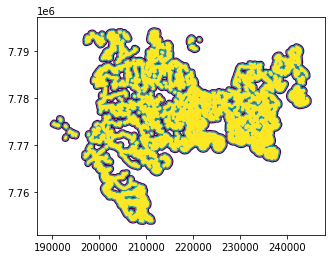

In [ ]:
diegao.aoi_ppa_shapefile.plot('buff_ppa')

In [ ]:

def connect_layers(cell_shp, list_columns, layer_to_connect):

  table_grid_elevation = cell_shp[list_columns].reset_index()
  table_grid_elevation = gpd.GeoDataFrame(table_grid_elevation, columns=list_columns)

  table_grid_elevation = table_grid_elevation.sjoin(layer_to_connect, how='left')

  return(table_grid_elevation)

def adjust_index_geom(df, list_columns):
  df = df[list_columns].reset_index()
  df = gpd.GeoDataFrame(df, columns=list_columns)

  return(df)

In [ ]:
table_grid_elevation = connect_layers(diegao.cell, 
                                      ['elevation_data', 'geometry'],                                    
                                      farm_elevation_shp)
  

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:32723

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [ ]:
table_grid_elevation

,elevation_data,geometry,index_right,farm_zone,Mediana_Altimetria,HS
0,-9999.0,"POLYGON ((166668.170 7822786.091, 166668.170 7...",NaN,NaN,NaN,NaN
1,-9999.0,"POLYGON ((166668.170 7823786.091, 166668.170 7...",NaN,NaN,NaN,NaN
2,-9999.0,"POLYGON ((166668.170 7824786.091, 166668.170 7...",NaN,NaN,NaN,NaN
3,-9999.0,"POLYGON ((166668.170 7825786.091, 166668.170 7...",NaN,NaN,NaN,NaN
4,-9999.0,"POLYGON ((166668.170 7826786.091, 166668.170 7...",6057.0,NaN,NaN,2.0
...,...,...,...,...,...,...
1582,567.0,"POLYGON ((242668.170 7785786.091, 242668.170 7...",6210.0,NaN,NaN,2.0
1583,558.0,"POLYGON ((243668.170 7782786.091, 243668.170 7...",NaN,NaN,NaN,NaN
1584,558.0,"POLYGON ((243668.170 7783786.091, 243668.170 7...",NaN,NaN,NaN,NaN
1585,566.0,"POLYGON ((243668.170 7784786.091, 243668.170 7...",NaN,NaN,NaN,NaN


In [ ]:
table_grid_elevation = connect_layers(table_grid_elevation,
                                      ['elevation_data', 'Mediana_Altimetria', 'HS', 'geometry'],
                                     diegao.aoi_ppa_shapefile)


In [ ]:
table_grid_elevation = table_grid_elevation[['elevation_data', 'Mediana_Altimetria', 'HS', 'geometry', 'buff_ppa']].reset_index()
table_grid_elevation = gpd.GeoDataFrame(table_grid_elevation, 
                                       columns=['elevation_data', 'Mediana_Altimetria', 'HS', 'buff_ppa', 'geometry'])

In [ ]:
clus_number = 10

x = table_grid_elevation[['elevation_data', 'Mediana_Altimetria', 'HS', 'buff_ppa']]
x = x.fillna(0)
x = x.clip(lower=0)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=['elevation_data', 'Mediana_Altimetria', 'HS', 'buff_ppa'])

df = df[['Mediana_Altimetria', 'HS', 'buff_ppa']]

w_dict_values = {'elevation_data':[.1], 'HS':[.3], 'buff_ppa':[.6], 'Mediana_Altimetria':[.1]}

for column in df.columns:
  df[column] = df[column] * w_dict_values[column]

  df['score'] = round(df.sum(axis=1), 2)


In [ ]:
df

,Mediana_Altimetria,HS,buff_ppa,score
0,0.0,0.0,0.0,0.00
1,0.0,0.0,0.0,0.00
2,0.0,0.0,0.0,0.00
3,0.0,0.0,0.0,0.00
4,0.0,0.2,0.0,1.07
...,...,...,...,...
42437,0.0,0.0,0.4,1.74
42438,0.0,0.0,0.6,2.60
42439,0.0,0.0,0.2,0.86
42440,0.0,0.0,0.4,1.74


In [ ]:

kmeans = KMeans(n_clusters=clus_number, 
                random_state=0).fit(df[['score']])

clus_values = kmeans.predict(df[['score']])

ord_idx=np.argsort(kmeans.cluster_centers_.flatten())

cntrs = np.zeros_like(clus_values)
for i in np.arange(clus_number):
    cntrs[clus_values==ord_idx[i]]=i

df['score_clus'] = cntrs

In [ ]:
final_table = gpd.GeoDataFrame(df, geometry=table_grid_elevation.geometry, crs=diegao.datum_utm)

final_table['score_cluster'] = final_table['score_clus']
final_table = final_table.dissolve(by='score_clus', aggfunc='mean')
final_table = final_table.explode(index_parts=False)
final_table['area'] = final_table.area/10000
final_table = diegao.reprojection(final_table, False)

projection interpretation and analysis
tranforming UTM projection to GEO


In [ ]:
df_hs = pd.DataFrame({'long':final_table.centroid.x,
                      'lat': final_table.centroid.y,
                      'area_ha':final_table['area'],
                      'cluster_hs':final_table['score_cluster'],
                      'peso_app': final_table['buff_ppa']})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [ ]:
final_table.to_file('hs_posicionamento.shp')  
df_hs.to_csv('csv_hs_info_posicionamento.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [ ]:
from google.colab import files
files.download('hs_posicionamento.shx')
files.download('hs_posicionamento.shp')
files.download('hs_posicionamento.dbf')
files.download('hs_posicionamento.prj')

files.download('csv_hs_info_posicionamento.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

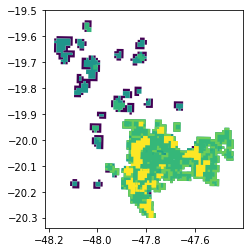

In [ ]:
final_table.plot('HS')

In [ ]:
#diegao.aoi_ppa_shapefile.plot() 

In [ ]:
gpd.GeoDataFrame({'HS':list_buffer_distances}, geometry = gpd.GeoSeries(final_table)).plot()

ValueError: ignored

In [ ]:
gpd.GeoDataFrame({'distance':list_buffer_distances}, geometry=geom_list, crs=diegao.datum_utm)

NameError: ignored